In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import pathlib

In [5]:
import numpy as np
import pandas as pd
import xarray as xr

In [6]:
import sys

In [7]:
sys.path.append('/home/nicolasf/research/Smart_Ideas/code/ml4seas/')

In [19]:
# %%writefile /home/nicolasf/research/Smart_Ideas/code/ml4seas/GCM/convert_rainfall.py
def convert_rainfall(dset, varin='tprate', varout='precip', out_units='mm', time_var='time', drop_orig=True, clip=True): 
    """
    Converts rainfall that is in m.s**-1 (m/s) to mm in the CDS forecasts 
    
    Arguments
    -------- 
    
    dset : the xarray Dataset 
    varin : str, the name of the original variable ('tprate' is default)
    varout : str, the name of the variable after conversion ('precip' is default)
    out_units : str, the units after conversion, will be added to the attrs dict 
                of `varout`, mm is default
    time_var : str, the name of the time (init_time) variable, default 'time'
    drop_orig : Boolean, whether to drop the original variable (`varin`)
                default is True 
    clip : Boolean, whether or not to clip the results at 0
                default is True 
    
    Return
    ------ 
    
    dset : the converted xarray.Dataset 
    
    """

    # imports
    import pandas as pd
    from datetime import datetime
    from dateutil.relativedelta import relativedelta
    from calendar import monthrange
    
    # check that the rainfall is indeed in m.s-1
    in_units = dset[varin].attrs['units']
    
    if in_units != 'm s**-1': 
        
        print(f"! warning, expected units to be m.s**-1, but units {in_units}")
        
        pass
    
    else:
        # convert from m/s to mm/day 
        dset[varout] = (dset[varin] * 1000 * (24 * 60 * 60))
        
        # calculate the number of days per month, then multiply 
        init_dates = pd.to_datetime(dset[time_var].data).to_pydatetime()
        
        steps = dset.step.data
        
        ndays = []

        for date in init_dates: 
            n = [date + relativedelta(months=x) for x in steps]
            n = [monthrange(x.year, x.month)[1] for x in n]
            ndays.append(n)
        
        ndays = np.array(ndays)
        
        dset['ndays'] = ((time_var,'step'), ndays) 
        
        dset[varout] = dset[varout] * dset['ndays']
        dset[varout].attrs['units'] = 'mm'

        # clip 
        if clip: 
            dset[varout] = dset[varout].clip(min=0.0)
            
        # drop the original variable 
        if drop_orig:
            dset = dset.drop_vars(varin)
        
        return dset

In [9]:
from GCM import regrid
from GCM import (fix_grid, preprocess_ECMWF_nc)
from utils import (list_files, save_by_month)

xesmf is not installed, using method `interp_like` for interpolation


In [10]:
provider = 'CDS'

In [11]:
GCM = 'ECMWF'

In [12]:
varname = 'PRECIP'

In [13]:
save_clim = True

### path where the files have been downloaded 

In [14]:
dpath = f'/media/nicolasf/END19101/data/GCMs/downloads/{GCM}/{varname}'

In [15]:
dpath = pathlib.Path(dpath)

### list the files 

In [16]:
lfiles = list_files(dpath, pattern=f"*{GCM}*", extension=".nc", verbose=1)

loaded files, list length 468
the first file is /media/nicolasf/END19101/data/GCMs/downloads/ECMWF/PRECIP/CDS_ECMWF_PRECIP_1981_01.nc
the last file is /media/nicolasf/END19101/data/GCMs/downloads/ECMWF/PRECIP/CDS_ECMWF_PRECIP_2019_12.nc


In [17]:
dset_all = xr.open_mfdataset(lfiles, concat_dim='init_time', preprocess=preprocess_ECMWF_nc, parallel=True)

In [20]:
dset_all_mm = convert_rainfall(dset_all, time_var='init_time')

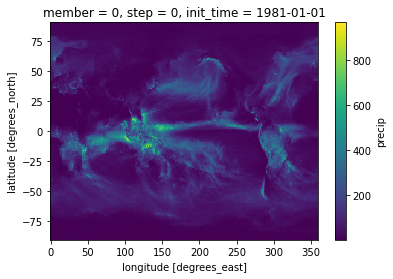

In [21]:
dset_all_mm['precip'].isel(init_time=0, step=0, member=0).plot()

### calculates the climatology 

In [22]:
clim_years = ['1981', '2010']
# clim_years = ['1993','2016']

In [23]:
clim = dset_all_mm.sel(init_time=slice(*clim_years)).mean('member')

In [24]:
clim = clim.groupby(clim.init_time.dt.month).mean()

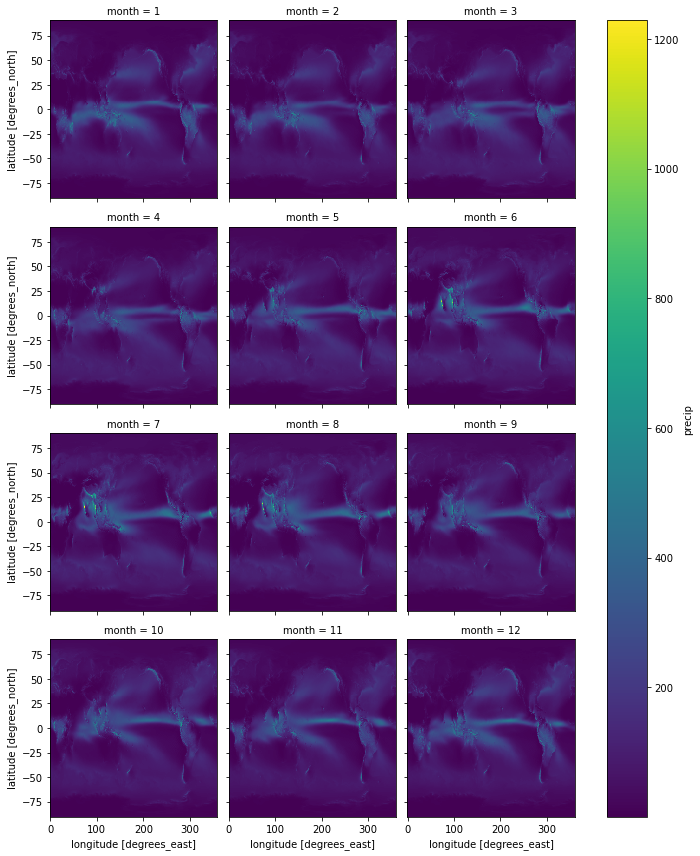

In [25]:
fg = clim.isel(step=0)['precip'].plot(x='lon',y='lat', col='month', col_wrap=3) 

In [27]:
clim = clim.drop('ndays')

In [29]:
opath = dpath.parents[2].joinpath(f'processed/{provider}/{GCM}/{varname}')

print(str(opath))

if not opath.exists():
    opath.mkdir(parents=True)

clim_path = opath.joinpath('CLIMATOLOGY')

if not clim_path.exists():
    clim_path.mkdir(parents=True)

/media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/PRECIP


### saves the climatology to disk 

In [30]:
if save_clim: 
    for m in clim.month.data: 
        c = clim.sel(month=m) 
        fname_out = f"CDS_ECMWF_T2M_monthly_{'_'.join(clim_years)}_clim_{str(m).zfill(2)}.nc"
        c.to_netcdf(clim_path.joinpath(fname_out))
        c.close()

### calculates the monthly anomalies 

In [31]:
anoms = (dset_all_mm.groupby(dset_all_mm.init_time.dt.month)) - clim

In [32]:
anoms

,Array,Chunk
Bytes,36.59 GB,78.19 MB
Shape,"(468, 6, 25, 181, 360)","(1, 6, 25, 181, 360)"
Count,9517 Tasks,468 Chunks
Type,float64,numpy.ndarray


### plots some anomalies to check if they make sense 

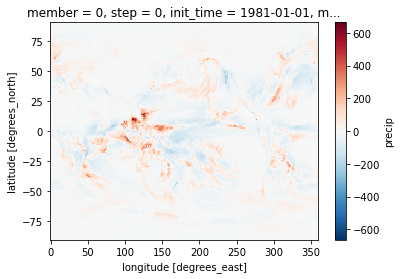

In [33]:
anoms['precip'][0,0,0,:,:].plot()

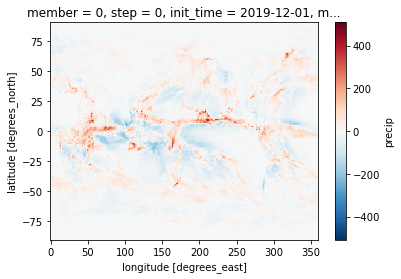

In [34]:
anoms['precip'][-1,0,0,:,:].plot()

### plots the ENSO 1997 - 1998

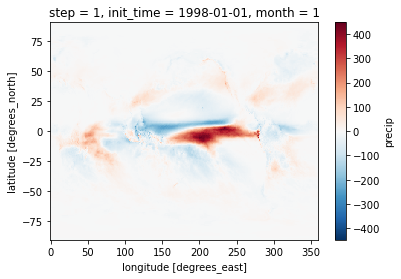

In [35]:
anoms.sel(init_time='1998-01-01')['precip'].mean('member').isel(step=1).plot()

### opens the target grid for interpolation 

In [36]:
out_grid = xr.open_dataset('/media/nicolasf/END19101/data/GCMs/target_grid/target_grid_2.5_2.5.nc')

### saves the monthly anomalies, non interpolated 

In [37]:
save_by_month(anoms, opath=opath, provider=provider, GCM=GCM, varname=varname, append=f"monthly_anomalies_{'_'.join(clim_years)}_clim", verbose=False)

### calculates the seasonal averages (of the anomalies )

In [38]:
anoms_seas = anoms.rolling(step=3, min_periods=3).mean()

In [39]:
anoms_seas = anoms_seas.dropna(dim='step')

### saves the seasonal anomalies, non interpolated 

In [40]:
save_by_month(anoms_seas, opath=opath, provider=provider, GCM=GCM, varname=varname, append=f"seasonal_anomalies_{'_'.join(clim_years)}_clim", verbose=True)

successfully saved CDS_ECMWF_PRECIP_1981-01_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_PRECIP_1981-02_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_PRECIP_1981-03_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_PRECIP_1981-04_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_PRECIP_1981-05_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_PRECIP_1981-06_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_PRECIP_1981-07_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_PRECIP_1981-08_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_PRECIP_1981-09_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_PRECIP_1981-10_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_PRECIP_1981-11_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF_PRECIP_1981-12_seasonal_anomalies_1981_2010_clim.nc
successfully saved CDS_ECMWF

### Now interpolates onto the 2.5 x 2.5 grid and saves to file

In [41]:
anoms_interp = anoms.interp_like(out_grid)

In [42]:
save_by_month(anoms_interp, opath=opath, provider=provider, GCM=GCM, varname=varname, append=f"monthly_anomalies_interp_{'_'.join(clim_years)}_clim", verbose=False)

In [43]:
anoms_seas_interp = anoms_seas.interp_like(out_grid)

In [ ]:
save_by_month(anoms_seas_interp, opath=opath, provider=provider, GCM=GCM, varname=varname, append=f"seasonal_anomalies_interp_{'_'.join(clim_years)}_clim", verbose=False)